In [1]:
import numpy
import pandas

In [2]:
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini

In [27]:
def test_split(index, value, dataset):
    left, right = [], []
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

In [4]:
pwd

'C:\\Users\\gsim\\repos\\jupyter-notebooks\\decision-tree\\MLMastery'

In [5]:
df = pandas.read_csv('data_banknote_authentication.txt', header=None)

In [6]:
df.head()

,0,1,2,3,4
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [7]:
df.columns = ['X{}'.format(i) for i in range(4)] + ['y']

In [8]:
df.head()

,X0,X1,X2,X3,y
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [30]:
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    best_index = 999
    best_value = 999
    best_score = 999
    best_groups = None
    
    gini_hist = []
    
    for index in range(len(dataset[0]) - 1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            
            #print('X{} < {:.3f} Gini={:.3f}'.format(index, row[index], gini))
        
            if gini < best_score:
                best_index = index
                best_value = row[index]
                best_score = gini
                best_groups = groups

                gini_hist.append(gini)
            
    return {'index': best_index, 'value': best_value, 'groups':best_groups, 'hist': gini_hist}

## find split

In [31]:
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

In [32]:
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
        
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)
        
    

In [33]:
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

In [44]:
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('{spacer}[X{:d} < {:.3f}]'.format(node['index'], node['value'], spacer=depth*'  '))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('{spacer}[{}]'.format(node, spacer=depth*'  '))

# TEST:

In [38]:
tree = build_tree(df.values, 3, 1)

In [45]:
print_tree(tree)

[X0 < 0.322]
  [X1 < 7.627]
    [X0 < -0.398]
      [1.0]
      [1.0]
    [X0 < -4.286]
      [1.0]
      [0.0]
  [X2 < -4.384]
    [X0 < 4.216]
      [1.0]
      [0.0]
    [X0 < 1.594]
      [0.0]
      [0.0]


In [17]:
dataset

NameError: name 'dataset' is not defined

In [19]:
numpy.unique(df.values[:, -1])

array([0., 1.])

In [46]:
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
        
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

In [60]:
import numpy

In [49]:
def decision_tree(train, test, max_depth, min_size):
    tree = build_tree(train, max_depth, min_size)
    predictions = []
    for row in test:
        prediction = predict(tree, row)
        predictions.append(prediction)
        
    return predictions

In [63]:
traintest  = df.values

In [65]:
numpy.random.shuffle(traintest)

In [66]:
len(traintest)

1372

In [67]:
train_ratio = 0.8

In [71]:
train_samples = int(len(traintest) * train_ratio)
train = traintest[:train_samples]

In [72]:
test= traintest[train_samples:]

In [73]:
assert len(test) + len(train) == len(traintest)

In [74]:
preds = decision_tree(train, test, 3, 1)

# compare with sklearn

In [76]:
from sklearn.tree import DecisionTreeClassifier

In [78]:
train

array([[-2.3221 , -9.3304 ,  9.233  , -0.79871,  1.     ],
       [ 3.5982 ,  7.1307 , -1.3035 ,  0.21248,  0.     ],
       [ 2.9736 ,  8.7944 , -3.6359 , -1.3754 ,  0.     ],
       ...,
       [ 1.6799 ,  4.2068 , -4.5398 , -2.3931 ,  1.     ],
       [ 4.8906 , -3.3584 ,  3.4202 ,  1.0905 ,  0.     ],
       [-0.2062 ,  9.2207 , -3.7044 , -6.8103 ,  0.     ]])

In [98]:
clf = DecisionTreeClassifier(min_samples_leaf=1, max_depth=2)
clf.fit(train[:, :-1], train[:, -1])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [99]:
pred_sk = clf.predict(test[:,:-1])

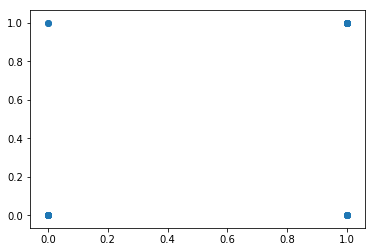

In [100]:
import matplotlib.pyplot as plt
plt.scatter(preds, pred_sk)
plt.show()

In [104]:
list(zip(preds, pred_sk)).count((0,0))

156

In [105]:
list(zip(preds, pred_sk)).count((0,1))

2

In [106]:
list(zip(preds, pred_sk)).count((1,0))

6

In [107]:
list(zip(preds, pred_sk)).count((1,1))

111

In [81]:
train[:, :-1]

array([[-2.3221 , -9.3304 ,  9.233  , -0.79871],
       [ 3.5982 ,  7.1307 , -1.3035 ,  0.21248],
       [ 2.9736 ,  8.7944 , -3.6359 , -1.3754 ],
       ...,
       [ 1.6799 ,  4.2068 , -4.5398 , -2.3931 ],
       [ 4.8906 , -3.3584 ,  3.4202 ,  1.0905 ],
       [-0.2062 ,  9.2207 , -3.7044 , -6.8103 ]])

In [62]:
traintest

array([[ -0.47465,  -4.3496 ,   1.9901 ,   0.7517 ,   1.     ],
       [  4.2134 ,  -2.806  ,   2.0116 ,   0.67412,   0.     ],
       [  1.8664 ,   7.7763 ,  -0.23849,  -2.9634 ,   0.     ],
       ...,
       [  3.404  ,   8.7261 ,  -2.9915 ,  -0.57242,   0.     ],
       [  4.6464 ,  10.5326 ,  -4.5852 ,  -4.206  ,   0.     ],
       [ -3.3863 , -12.9889 ,  13.0545 ,  -2.7202 ,   1.     ]])

In [56]:
df.values

array([[  3.6216 ,   8.6661 ,  -2.8073 ,  -0.44699,   0.     ],
       [  4.5459 ,   8.1674 ,  -2.4586 ,  -1.4621 ,   0.     ],
       [  3.866  ,  -2.6383 ,   1.9242 ,   0.10645,   0.     ],
       ...,
       [ -3.7503 , -13.4586 ,  17.5932 ,  -2.7771 ,   1.     ],
       [ -3.5637 ,  -8.3827 ,  12.393  ,  -1.2823 ,   1.     ],
       [ -2.5419 ,  -0.65804,   2.6842 ,   1.1952 ,   1.     ]])

In [53]:
train

In [50]:
shuffle(df.values)

NameError: name 'shuffle' is not defined